In [1]:
import numpy as np
np.random.seed(42)

import numba
numba.config.DEFAULT_FLOAT_TYPE = numba.float32

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [2]:
from plotting_functions import (
    plot_network, 
    plot_network_with_incidents,
    create_video)
from path_following_functions import (
    initialize,
    path_following_simulation,
    gbfs,
    create_groups,
    generate_initial_paths,
    map_groups_and_particles
)

In [3]:
####### LOAD NETWORK  ##############
node = np.load("node.npy").astype(np.float32)
site = np.load("site.npy").astype(np.int32)
exits = np.load("exits.npy").astype(np.int32)
connectivity_matrix = np.load("connectivity_matrix.npy").astype(bool)
connections = np.load("connections.npy").astype(np.int32)
#connections_start_idx = np.load("connections_start_idx.npy").astype(np.int32) 
#node_distance_squared = np.load("node_distance_squared.npy").astype(np.float32) 
#node_distance = np.load("node_distance.npy").astype(np.float32) 

NUM_NODES = node.shape[0]
NUM_CONNECTIONS = connections.shape[0]

print("NUM_NODES = ", NUM_NODES)
print("NUM_CONNECTIONS = ", NUM_CONNECTIONS)

NUM_NODES =  107
NUM_CONNECTIONS =  130


In [4]:
############ CONSTANTS #########
NUM_PARTICLES = 2_000  # Number of particles
NUM_PATHS = NUM_PARTICLES # Each particle has its own path
#################################
VMAX = np.float32(2.0)
K_advance = np.float32(1.0)
K_wall = np.float32(10.)
H_wall = np.float32(6.)
r_advance = np.float32(2.0)
K_inside = np.float32(1.0)
H_inside = H_wall
damping_coefficient=np.float32(2.0)
d_separation = np.float32(2.0)
K_separation = np.float32(10.)
K_alignment =  np.float32(1.)
K_cohesion = np.float32(1.)
######################
SHELL = d_separation
CUT_OFF_LIST = d_separation + SHELL
CUT_OFF_LIST_SQ = CUT_OFF_LIST**2
MAX_NEIGH = 100
MAX_STEPS_IN_PATH = 20
MAX_FRIENDS = 5

In [5]:
# Number of sites

# Assign random values to each site
site_probabilities = 0.5 + np.random.rand(site.shape[0])

# Normalize to sum to 1
site_probabilities /= site_probabilities.sum()

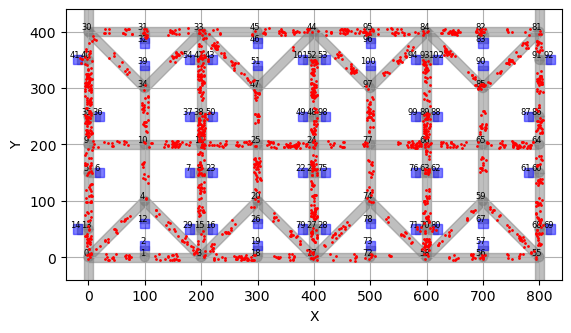

In [6]:
#### PLOT TIME 0 ######

position, velocity, nodes_in_path, steps_in_path, path, groups = initialize(node, site, site_probabilities, connectivity_matrix, 
                                                                    MAX_STEPS_IN_PATH, NUM_PARTICLES, MAX_FRIENDS)

fig, ax = plt.subplots()  # Create a figure and axis
plot_network(position, node, site, exits, connections, ax, 
             H_wall=8, LXmin =-40, LXmax=840, LYmin=-40, LYmax=440)  # Pass the axis to the function
plt.show()

In [7]:
################ Simulation parameters #################
dt = np.float32(0.1)
TIME_STEPS = 10_000 
N_OUT = 10 #flush positions every N_OUT
TIME_INSIDE = 1000 # Average time inside building

In [8]:
import time 
start_time = time.perf_counter()
full_simulation, full_simulation_status, full_current_site, time_spent_inside, incidents = path_following_simulation(
                                                                                node, site, site_probabilities, exits,
                                                                                connectivity_matrix, 
                                                                                MAX_STEPS_IN_PATH, NUM_PARTICLES, 
                                                                                TIME_STEPS, N_OUT, dt, VMAX, SHELL, 
                                                                                MAX_NEIGH, CUT_OFF_LIST_SQ, 
                                                                                r_advance, K_advance, 
                                                                                H_wall, K_wall, 
                                                                                H_inside, K_inside, 
                                                                                damping_coefficient, 
                                                                                d_separation, K_separation,
                                                                                K_alignment, K_cohesion,
                                                                                MAX_FRIENDS, TIME_INSIDE)
end_time = time.perf_counter()  # Record the end time

print(f"Simulation Completed. Execution time: {end_time - start_time:.4f} seconds")
print("NUM_PARTICLES: ", NUM_PARTICLES)
print("TIME_STEPS: ", TIME_STEPS)

Simulation Completed. Execution time: 56.3613 seconds
NUM_PARTICLES:  2000
TIME_STEPS:  10000


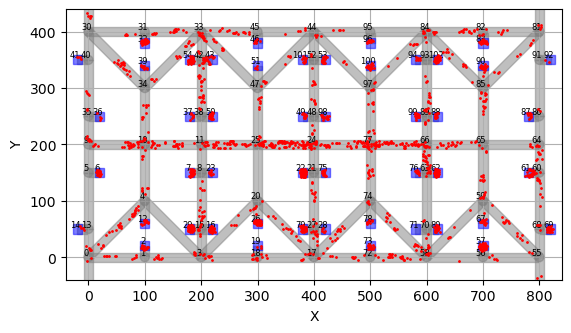

In [9]:
fig, ax = plt.subplots()  # Create a figure and axis
plot_network(full_simulation[-1], node, site, exits, connections, ax, 
             H_wall=8, LXmin =-40, LXmax=840, LYmin=-40, LYmax=440)  # Pass the axis to the function
plt.show()

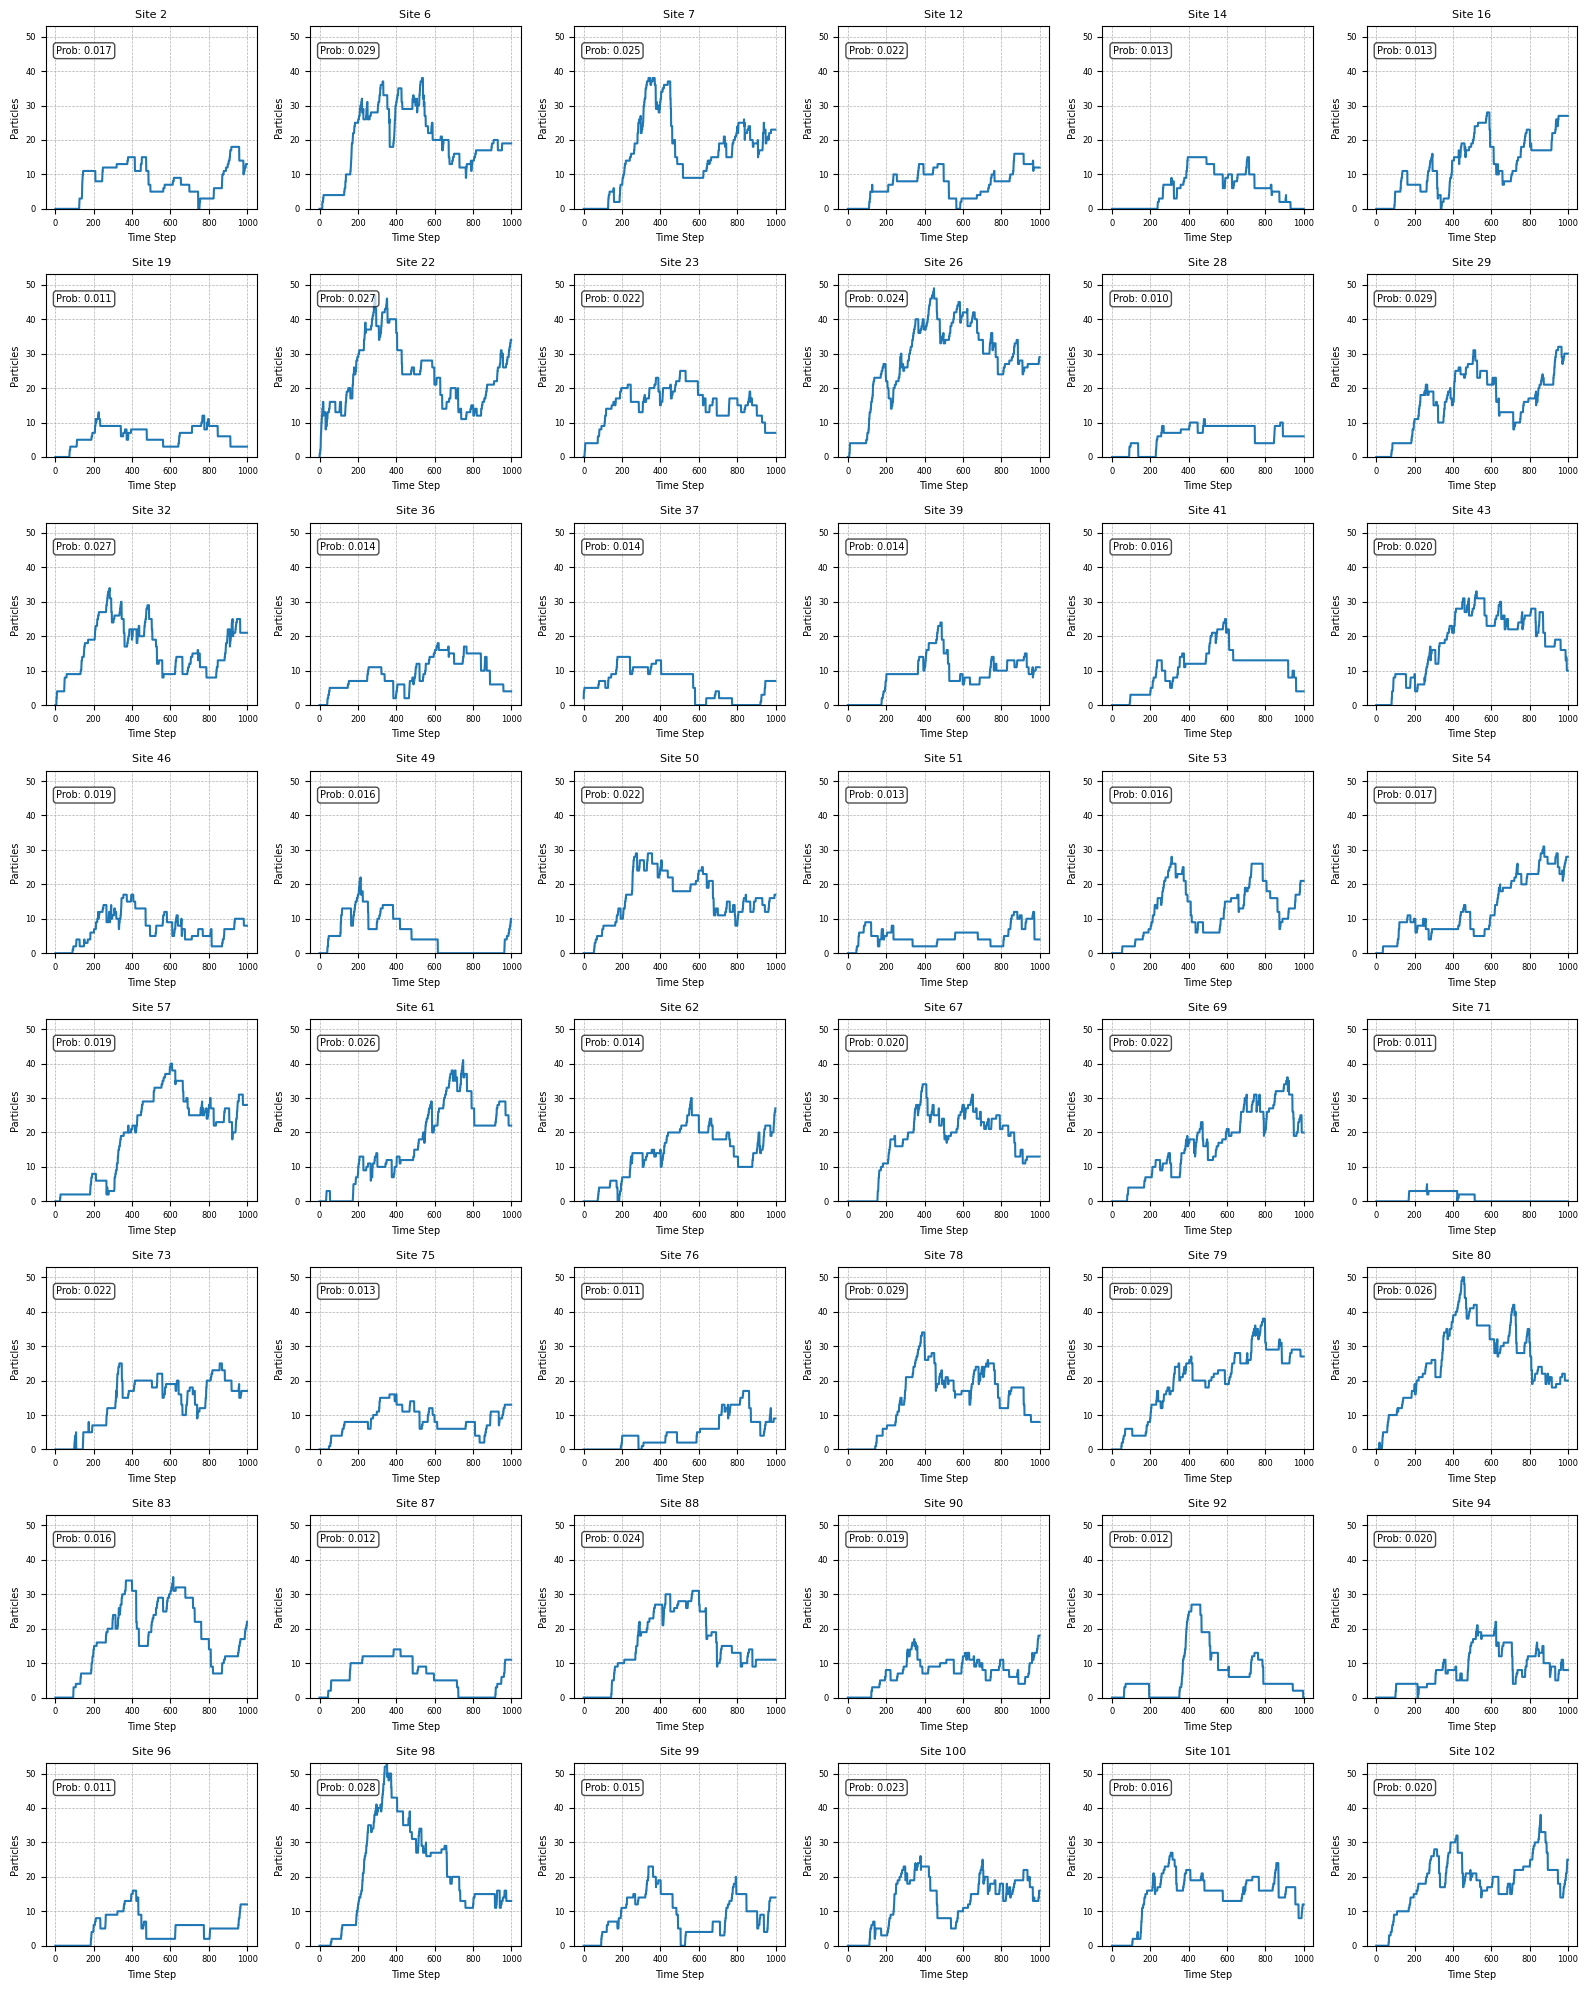

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_particles_per_site(full_current_site, site, exits, site_probabilities):
    num_time_steps = full_current_site.shape[0]

    # Remove exits from the site list
    site_only = np.setdiff1d(site, exits)
    num_sites = len(site_only)

    # Store site population over time
    site_counts = np.zeros((num_time_steps, num_sites), dtype=np.int32)

    for t in range(num_time_steps):
        site_presence = full_current_site[t][full_current_site[t] != -1]
        counts = np.bincount(site_presence, minlength=np.max(site_only) + 1)
        for idx, s in enumerate(site_only):
            site_counts[t, idx] = counts[s] if s < len(counts) else 0

    # Find the max y-value for consistent axis limits
    ymax = np.max(site_counts) if np.max(site_counts) > 0 else 1

    # Automatically adjust rows to fit all sites
    cols = 6
    rows = int(np.ceil(num_sites / cols))

    plt.figure(figsize=(16, 2.5 * rows))
    for i, s in enumerate(site_only):
        ax = plt.subplot(rows, cols, i + 1)
        ax.plot(range(num_time_steps), site_counts[:, i], label=f"Site {s}")
        
        # Show probability on the plot
        site_idx = np.where(site == s)[0][0]  # Find site index
        probability = site_probabilities[site_idx]
        ax.text(0.05, 0.85, f"Prob: {probability:.3f}", 
                transform=ax.transAxes, fontsize=7, 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))

        ax.set_title(f"Site {s}", fontsize=8)
        ax.set_xlabel("Time Step", fontsize=7)
        ax.set_ylabel("Particles", fontsize=7)
        ax.set_ylim(0, ymax)
        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.tick_params(axis='both', labelsize=6)
        ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

    # Return a DataFrame for further analysis
    return pd.DataFrame(site_counts, columns=[f"Site {s}" for s in site_only])

# Example: Call the function with probabilities
df = plot_particles_per_site(full_current_site, site, exits, site_probabilities)

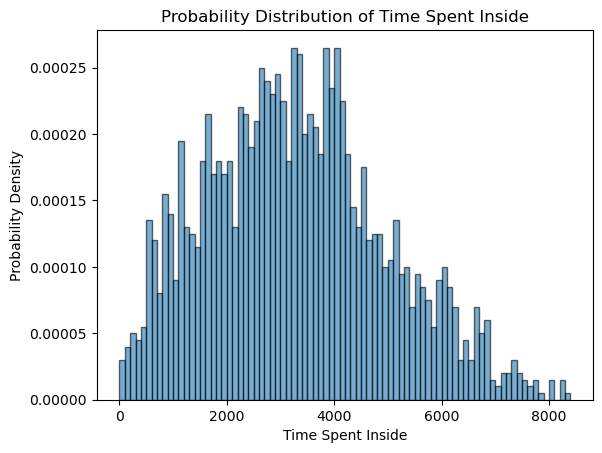

In [11]:
%matplotlib inline
# Define bin size
bin_size = 100  
bins = np.arange(0, np.max(time_spent_inside) + bin_size, bin_size)

# Plot histogram as probability distribution
plt.hist(time_spent_inside, bins=bins, density=True, alpha=0.6, edgecolor='black')

# Labels
plt.xlabel("Time Spent Inside")
plt.ylabel("Probability Density")
plt.title("Probability Distribution of Time Spent Inside")

plt.show()


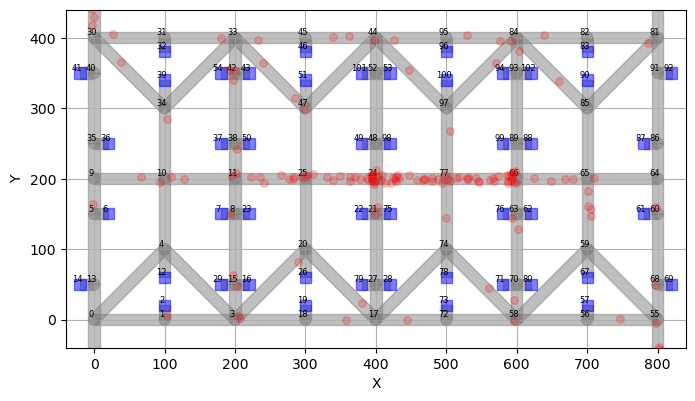

In [12]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
plot_network_with_incidents(incidents, node, site, exits, connections, ax, 
                            H_wall=8, LXmin =-40, LXmax=840, LYmin=-40, LYmax=440)
plt.show()


In [13]:
matplotlib.use('Agg')  # Use the Agg backend for faster rendering
highlighted_particles = range(6)  # List of particle indices to be highlighted in red
start_time = time.perf_counter()
create_video(full_simulation, full_simulation_status, 
             node, site, exits, connections, H_wall=8,
             LXmax=840, LXmin=-40, LYmax=540, LYmin=-140,
             filename="my_simulation.mp4", frame_skip=1,
             highlighted_particles=highlighted_particles)
end_time = time.perf_counter() 
print(f"Video created in {end_time - start_time:.4f} seconds")

Generating frames...
Creating video...
Video saved successfully as simulation.mp4
Cleaning up frames...
Video created in 445.9066 seconds
